In [749]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import json

In [750]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

In [751]:
with open("tokenizer.json", "r") as jsonfile:
    tokenizer = json.load(jsonfile)

tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer)

In [752]:
with open("dados/tituloTratado.csv", "r") as csvfile:
    titulos = np.genfromtxt(csvfile, delimiter=",")
    titulos = titulos.astype(np.int32)

In [753]:
with open("dados/conteudoTratado.csv", "r") as csvfile:
    conteudos = np.genfromtxt(csvfile, delimiter=",")
    conteudos = conteudos.astype(np.int32)

In [754]:
size = len(conteudos)

xTrain = conteudos[0:int(size*0.8)]
xTest = conteudos[int(size*0.8):]

yTrain = titulos[0:int(size*0.8)]
yTest = titulos[int(size*0.8):]

In [755]:
vocab = len(tokenizer.word_index)

In [788]:
vocab

7392

In [756]:
maxTitle = max(len(tokens) for tokens in titulos)
maxContent = max(len(tokens) for tokens in conteudos)

In [757]:
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [791]:
def Encoder(latentDim, encoderInputs):
    
  l1 = keras.models.Sequential([
    layers.Embedding(vocab, 128, input_length=maxContent),
    layers.Conv1D(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1D(64, 3, activation="relu", strides=1, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])

  x = l1(encoderInputs)

  zMean = layers.Dense(latentDim, name="z_mean")(x)
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)

  z = SamplingLayer()([zMean, zLogVar])

  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")

encoderInputs = keras.Input(shape=(maxContent, 1))
encoder = Encoder(1, encoderInputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_83 (InputLayer)       [(None, 2141, 1)]            0         []                            
                                                                                                  
 sequential_79 (Sequential)  (None, 256)                  3609849   ['input_83[0][0]']            
                                                          6                                       
                                                                                                  
 z_mean (Dense)              (None, 1)                    257       ['sequential_79[0][0]']       
                                                                                                  
 z_log_var (Dense)           (None, 1)                    257       ['sequential_79[0][0]'] 

In [759]:
def Decoder(latentInputs):

  l1 = keras.models.Sequential([
    layers.Dense(maxTitle, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((maxTitle, 1)),
    layers.Conv1DTranspose(128, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(64, 3, activation="relu", strides=1, padding="same"),
    layers.Conv1DTranspose(1, 3, activation="sigmoid", padding="same", input_shape=(None, maxTitle))
  ])

  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

latentInputs = keras.Input(shape=(1,))
decoder = Decoder(latentInputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_81 (InputLayer)       [(None, 1)]               0         
                                                                 
 sequential_78 (Sequential)  (None, 15, 1)             25375     
                                                                 
Total params: 25375 (99.12 KB)
Trainable params: 25375 (99.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [760]:
def reconstructionLoss(data, reconstructed):
  return keras.losses.binary_crossentropy(data, reconstructed)   

In [761]:
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
        -0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),
        axis=1
  )

In [762]:
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [763]:
print(xTrain.shape, "\n", yTrain.shape)

(78, 2141) 
 (78, 15)


In [764]:
xTrain = np.expand_dims(xTrain, -1)
yTrain = np.expand_dims(yTrain, -1)

In [765]:
xTest = np.expand_dims(xTest, -1)
yTest = np.expand_dims(yTest, -1)

In [766]:
print(xTrain.shape, "\n", yTrain.shape)

(78, 2141, 1) 
 (78, 15, 1)


In [767]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")
    
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  def train_step(self, data):

    x, y = data[0]

    with tf.GradientTape() as tape:
        
        zMean, zLogVar, z = self.encoder(x)
        reconstruction = self.decoder(z)

        ceLoss, klLoss, totalLoss = calcTotalLoss(y, reconstruction, zMean, zLogVar)

    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    #self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    #self.klLossTracker.update_state(klLoss)

    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [768]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = vae.fit(data, epochs=50, batch_size=1)

Epoch 1/50
78/78 [==============================] - 19s 227ms/step - total_loss: 0.0000e+00 - ce_loss: 3811451.5000 - kl_loss: 0.0000e+00
Epoch 2/50
78/78 [==============================] - 18s 225ms/step - total_loss: 0.0000e+00 - ce_loss: -2260.4355 - kl_loss: 0.0000e+00
Epoch 3/50
78/78 [==============================] - 17s 224ms/step - total_loss: 0.0000e+00 - ce_loss: -9097.8105 - kl_loss: 0.0000e+00
Epoch 4/50
78/78 [==============================] - 17s 223ms/step - total_loss: 0.0000e+00 - ce_loss: -25235.6973 - kl_loss: 0.0000e+00
Epoch 5/50
78/78 [==============================] - 17s 220ms/step - total_loss: 0.0000e+00 - ce_loss: -54655.9688 - kl_loss: 0.0000e+00
Epoch 6/50
78/78 [==============================] - 17s 217ms/step - total_loss: 0.0000e+00 - ce_loss: -102829.8906 - kl_loss: 0.0000e+00
Epoch 7/50
78/78 [==============================] - 17s 224ms/step - total_loss: 0.0000e+00 - ce_loss: -171501.1094 - kl_loss: 0.0000e+00
Epoch 8/50
78/78 [======================

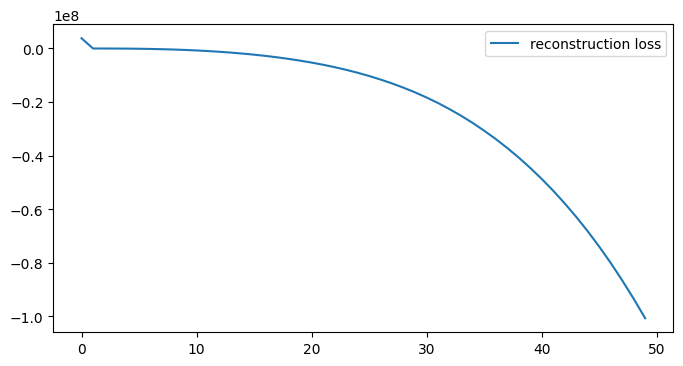

In [769]:
plt.figure(figsize=(8, 4))
#plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

In [779]:
xTest.shape

(20, 2141, 1)

In [780]:
teste = vae.decoder.predict(xTest[1])       

 1/67 [..............................] - ETA: 1s

67/67 [==============================] - 0s 3ms/step


In [781]:
teste.shape

(2141, 15, 1)

In [782]:
teste = teste[0].reshape(15)

In [783]:
for i in range(0, 15):
    teste[i] = round(teste[i])

In [784]:
teste = teste.astype("int64")
teste = teste.tolist()

In [785]:
teste

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [786]:
decoded_words = []
for index in teste:
    word = tokenizer.index_word.get(index)
    if word is not None:    
        decoded_words.append(word)

decoded_text = " ".join(decoded_words)

In [787]:
decoded_text

'de de de de de de de de de de de de de de de'